# Spitzer-ulens Tutorial Notebook
This notebook aims to demonstrate the usage of the main functions in the Spitzer-ulens package.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import pickle
import emcee
import time as ti
from tqdm import tqdm
import os
from multiprocessing import Pool
import corner
from scipy import optimize as opt

from Spitzer_ulens.data_config import PLDEventData
from Spitzer_ulens import models
from Spitzer_ulens import PLD
from Spitzer_ulens import mcmc

## Configuration and Preparation

This section demonstrates usage of the data_config module.

In [2]:
coords = ('17:47:31.93','-24:31:21.6')
spitzer_data_path = 'data/ob171140/rawdata/'
ogle_data_file = 'data/ob171140/ob171140_ogle.dat'

In [ ]:
load_evt_from_file = True
if load_evt_from_file:
    fname = 'ob171140.pkl'
    with open(fname,'rb') as file:
        evt = pickle.load(file)
else:
    # Create a PLDEventData object from our data
    evt = PLDEventData(spitzer_data_path,coords,recursive=True)
    # Add ground-based observations to our PLDEventData object
    evt.add_OGLE_data(ogle_data_file)
    # Save our PLDEventData object
    evt.save(filepath='ob171140.pkl',overwrite=True)

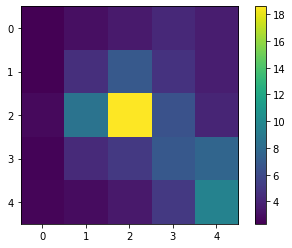

In [4]:
# Plotting an example of a 5-by-5 image
fig,ax = plt.subplots()
im = ax.imshow(evt.img[5][10])
fig.colorbar(im)
plt.show()

## Least-Squares Fit

Text(0, 0.5, 'Flux (MJy/sr)')

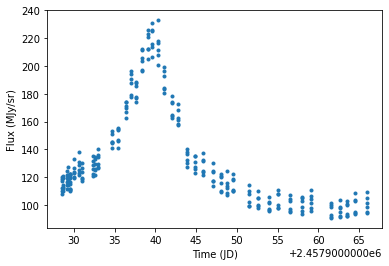

In [5]:
# Get raw photometry, error, and binned error
flux,flux_err,flux_frac,flux_scatter = evt.aperture_photometry()
time = np.array(evt.time)
ind = time<8000
time = (time[ind]+2450000).reshape(6,-1)
flux = flux[ind].reshape(6,-1)
flux_err = flux_err[ind].reshape(6,-1)
flux_frac = flux_frac[ind].reshape(6,-1,5,5)

time_g = np.array(evt.t_g)+2450000
ind_g = time_g>2457752
time_g = time_g[ind_g]
flux_g = np.array(evt.flux_g)[ind_g]
flux_err_g = np.array(evt.flux_err_g)[ind_g]

# Plot our raw data so that we can make some parameter estimates.
plt.plot(time.ravel(),flux.ravel(),'.')
#plt.plot(time_g,flux_g,'.')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (MJy/sr)')

In [6]:
# Make an initial guess for model parameters, which will be used as starting point for LM fit

# Single lens model:
t0 = 2457940.7604
u0 = 0.2364      # impact parameter
tE = 14.79
fs = 19.7
fb = 82
fs_g = 1.127
fb_g = 0.241
pi_E_N = -0.0739       # microlens parallax (pi_E) in the N-S direction
pi_E_E = 0.0524

p0 = np.array([tE,t0,u0,pi_E_N,pi_E_E,fb_g,fs_g,fb,fs])
bounds = ([0,2457935,-np.inf,-np.inf,-np.inf,0,0,0,0],[140,2457945,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])

In [7]:
model = models.SingleLensParallaxModel(coords,'data/ob171140/spitzer/Spitzer_ephemeris_02.dat')

mag_s,mag_g = model.get_mag(time.ravel(),time_g.ravel(),tE,t0,u0,pi_E_N,pi_E_E)
fbfs_s,cov_s = opt.curve_fit(model.mag2flux,mag_s,flux.ravel(),[fb,fs])
fbfs_g,cov_g = opt.curve_fit(model.mag2flux,mag_g,flux_g,[fb_g,fs_g])
popt_lsq = np.concatenate(([tE,t0,u0,pi_E_N,pi_E_E],fbfs_g,fbfs_s))

timeplot = np.linspace(np.min([np.min(time),np.min(time_g)]),np.max([np.max(time),np.max(time_g)]),1000)
fluxplot_lsq,fluxplot_g_lsq = model(timeplot,timeplot,*popt_lsq)

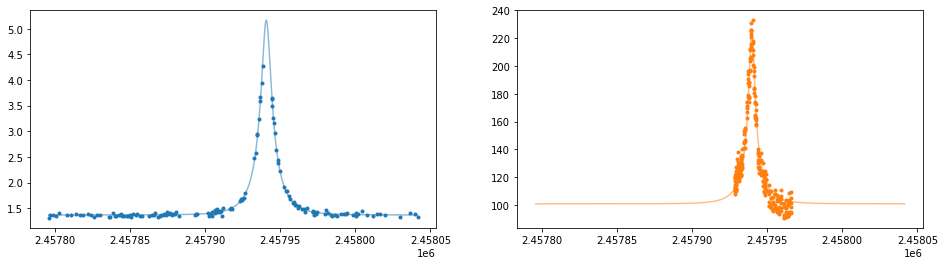

In [8]:
fig,ax = plt.subplots(ncols=2,figsize=(16,4))
ax[0].plot(timeplot,fluxplot_g_lsq,'C0',alpha=0.5)
ax[0].plot(time_g,flux_g,'C0.')
ax[1].plot(timeplot,fluxplot_lsq,'C1',alpha=0.5)
ax[1].plot(time.ravel(),flux.ravel(),'C1.')

## Solving PLD Coefficients Analytically

In [9]:
# Solve for PLD coefficients analytically (X)
Y, Astro, Ps, A, X, flu_g = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_lsq,model,time_g)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(A, Ps, X, flux, Astro)

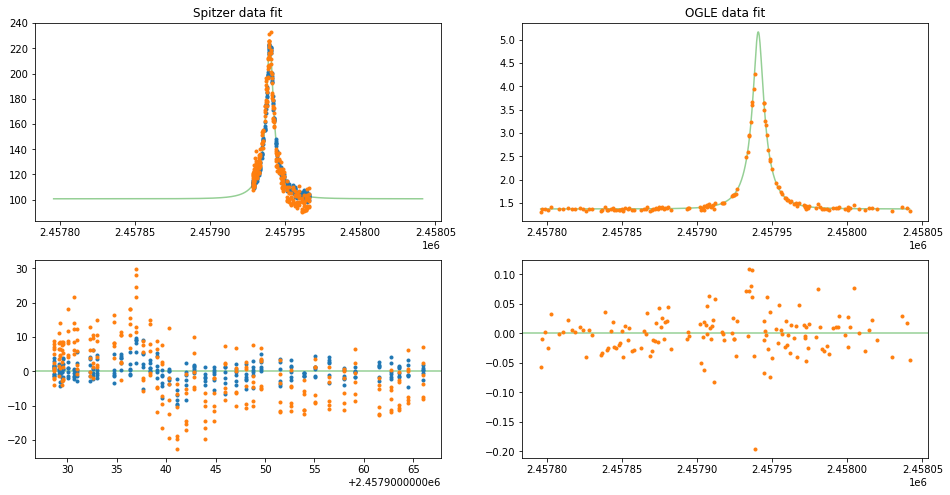

In [10]:
#timeplot = np.linspace(time.min(),time.max(),1000)
#timeplot_g = np.linspace(time_g.min(),time_g.max(),1000)
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(16,8))

ax[0,0].plot(timeplot,model(timeplot,timeplot,*popt_lsq)[0],'C2',alpha=0.5)
ax[0,0].plot(time.ravel(),corr.ravel(),'C0.')
ax[0,0].plot(time.ravel(),flux.ravel(),'C1.')
ax[0,0].set_title('Spitzer data fit')

ax[1,0].axhline(c='C2',alpha=0.5)
#ax[1,0].plot(timeplot,np.zeros(len(timeplot)),'C2',alpha=0.5)
ax[1,0].plot(time.ravel(),corr.ravel()-Astro.ravel(),'C0.')
ax[1,0].plot(time.ravel(),flux.ravel()-Astro.ravel(),'C1.')

ax[0,1].plot(timeplot,model(timeplot,timeplot,*popt_lsq)[1],'C2',alpha=0.5)
ax[0,1].plot(time_g,flux_g,'C1.')
ax[0,1].set_title('OGLE data fit')

ax[1,1].axhline(c='C2',alpha=0.5)
ax[1,1].plot(time_g,flux_g-model(time_g,time_g,*popt_lsq)[1],'C1.')

# MCMC Fit for PLD Parameters

In this section we run a Markov Chain Monte-Carlo (MCMC) fit to our data. This will explore parameter space to optimize the log-likelihood for our model to fit our data. We use the emcee package (https://github.com/dfm/emcee) to do our fit. The log-likelihood function we use is detailed in more depth in the 'Spitzer_ulens.models' module, as a method of the SingleLensParallaxModel class.

In [19]:
def run_mcmc(sampler,pos0,nsteps,visual=True,label=''):
    if visual:
        tic = ti.time()
        print('Running MCMC '+label+'...')
        
        # Using tqdm package to generate progress bars
        for pos, prob, state in tqdm(sampler.sample(pos0, iterations=nsteps),total=nsteps):
            pass

        print("Mean burn-in acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
        toc = ti.time()
        print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))
        return pos,prob,state
    else:
        pos,prob,state = sampler.run_mcmc(pos0,nsteps)
        return pos,prob,state

In [12]:
load_chain_from_file = False
pos_chain_path = ''
lnp_chain_path = ''

if load_chain_from_file:
    pos_chain = np.load(path+'/samplerchain.npy')
    lnp_chain = np.load(path+'/samplerlnpro.npy')
else:
    # 'l0' are our weight factors, which are used to specify the relative importances of parts of 
    # our log-likelihood function, namely the space-based and ground-based parts. Our MCMC will 
    # fit for these as well. See the 'SingleLensParallaxModel.lnlike' function in the models module
    # for more details.
    l0 = [1,1]
    p0 = np.concatenate((popt_lsq,l0))
    nwalkers = 100
    nburnin = 300
    nprod = 1000
    
    # Generate the MCMC sampler with 100 walkers, our log-probability function, and our data. We
    # use pool from the multiprocessing package to parallelize the process.
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2, pool=Pool(),
                                    args=(bounds,time,time_g,flux,flux_err,flux_frac,
                                          flux_scatter,flux_g,flux_err_g))
    
    # Initialize the initial parameter positions for each walker by adding a random offset. Starting
    # our walkers in different positions allows us to explore more parameter space.
    pos0 = [p0*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the first MCMC burn-in.
    pos1,prob,state = run_mcmc(sampler,pos0,nburnin,label='first burn-in')
    sampler.reset()

    #Run the MCMC from best spot from last time, and do another burn-in to get the walkers spread out.
    pos2 = pos1[np.argmax(prob)]
    
    # Slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(sampler.ndim))+1e-6*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the second burn-in
    pos2, prob, state = run_mcmc(sampler,pos2,nburnin,label='second burn-in')
    sampler.reset()
    
    #Run the final production run that will be saved
    pos_final, prob, state = run_mcmc(sampler,pos2,nprod,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability

# Get results from chain
popt_mcmc,pmax,std_hi,std_lo = mcmc.get_MCMC_results(pos_chain,lnp_chain)

Running MCMC first burn-in...


  0%|                                                                  | 0/300 [00:00<?, ?it/s]/Users/Tarik/Library/Python/3.8/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████| 300/300 [02:05<00:00,  2.39it/s]


Mean burn-in acceptance fraction: 0.317
MCMC runtime = 2.09 min

Running MCMC second burn-in...


100%|████████████████████████████████████████████████████████| 300/300 [02:26<00:00,  2.05it/s]


Mean burn-in acceptance fraction: 0.432
MCMC runtime = 2.43 min

Running MCMC production...


100%|██████████████████████████████████████████████████████| 1000/1000 [07:27<00:00,  2.23it/s]

Mean burn-in acceptance fraction: 0.378
MCMC runtime = 7.47 min



[ 1.40102784e+01  2.45794067e+06  2.87398059e-01 -8.75688635e-02
  7.85359521e-02  1.22471298e-02  1.35638277e+00  7.42475950e+01
  2.49152792e+01  5.63688743e-01  1.35277134e+00]


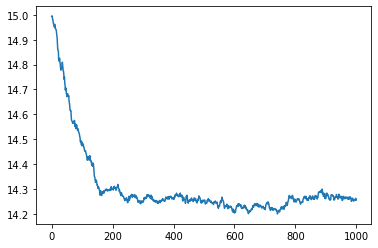

In [13]:
plt.plot(pos_chain.mean(axis=0)[:,0])
print(pmax)

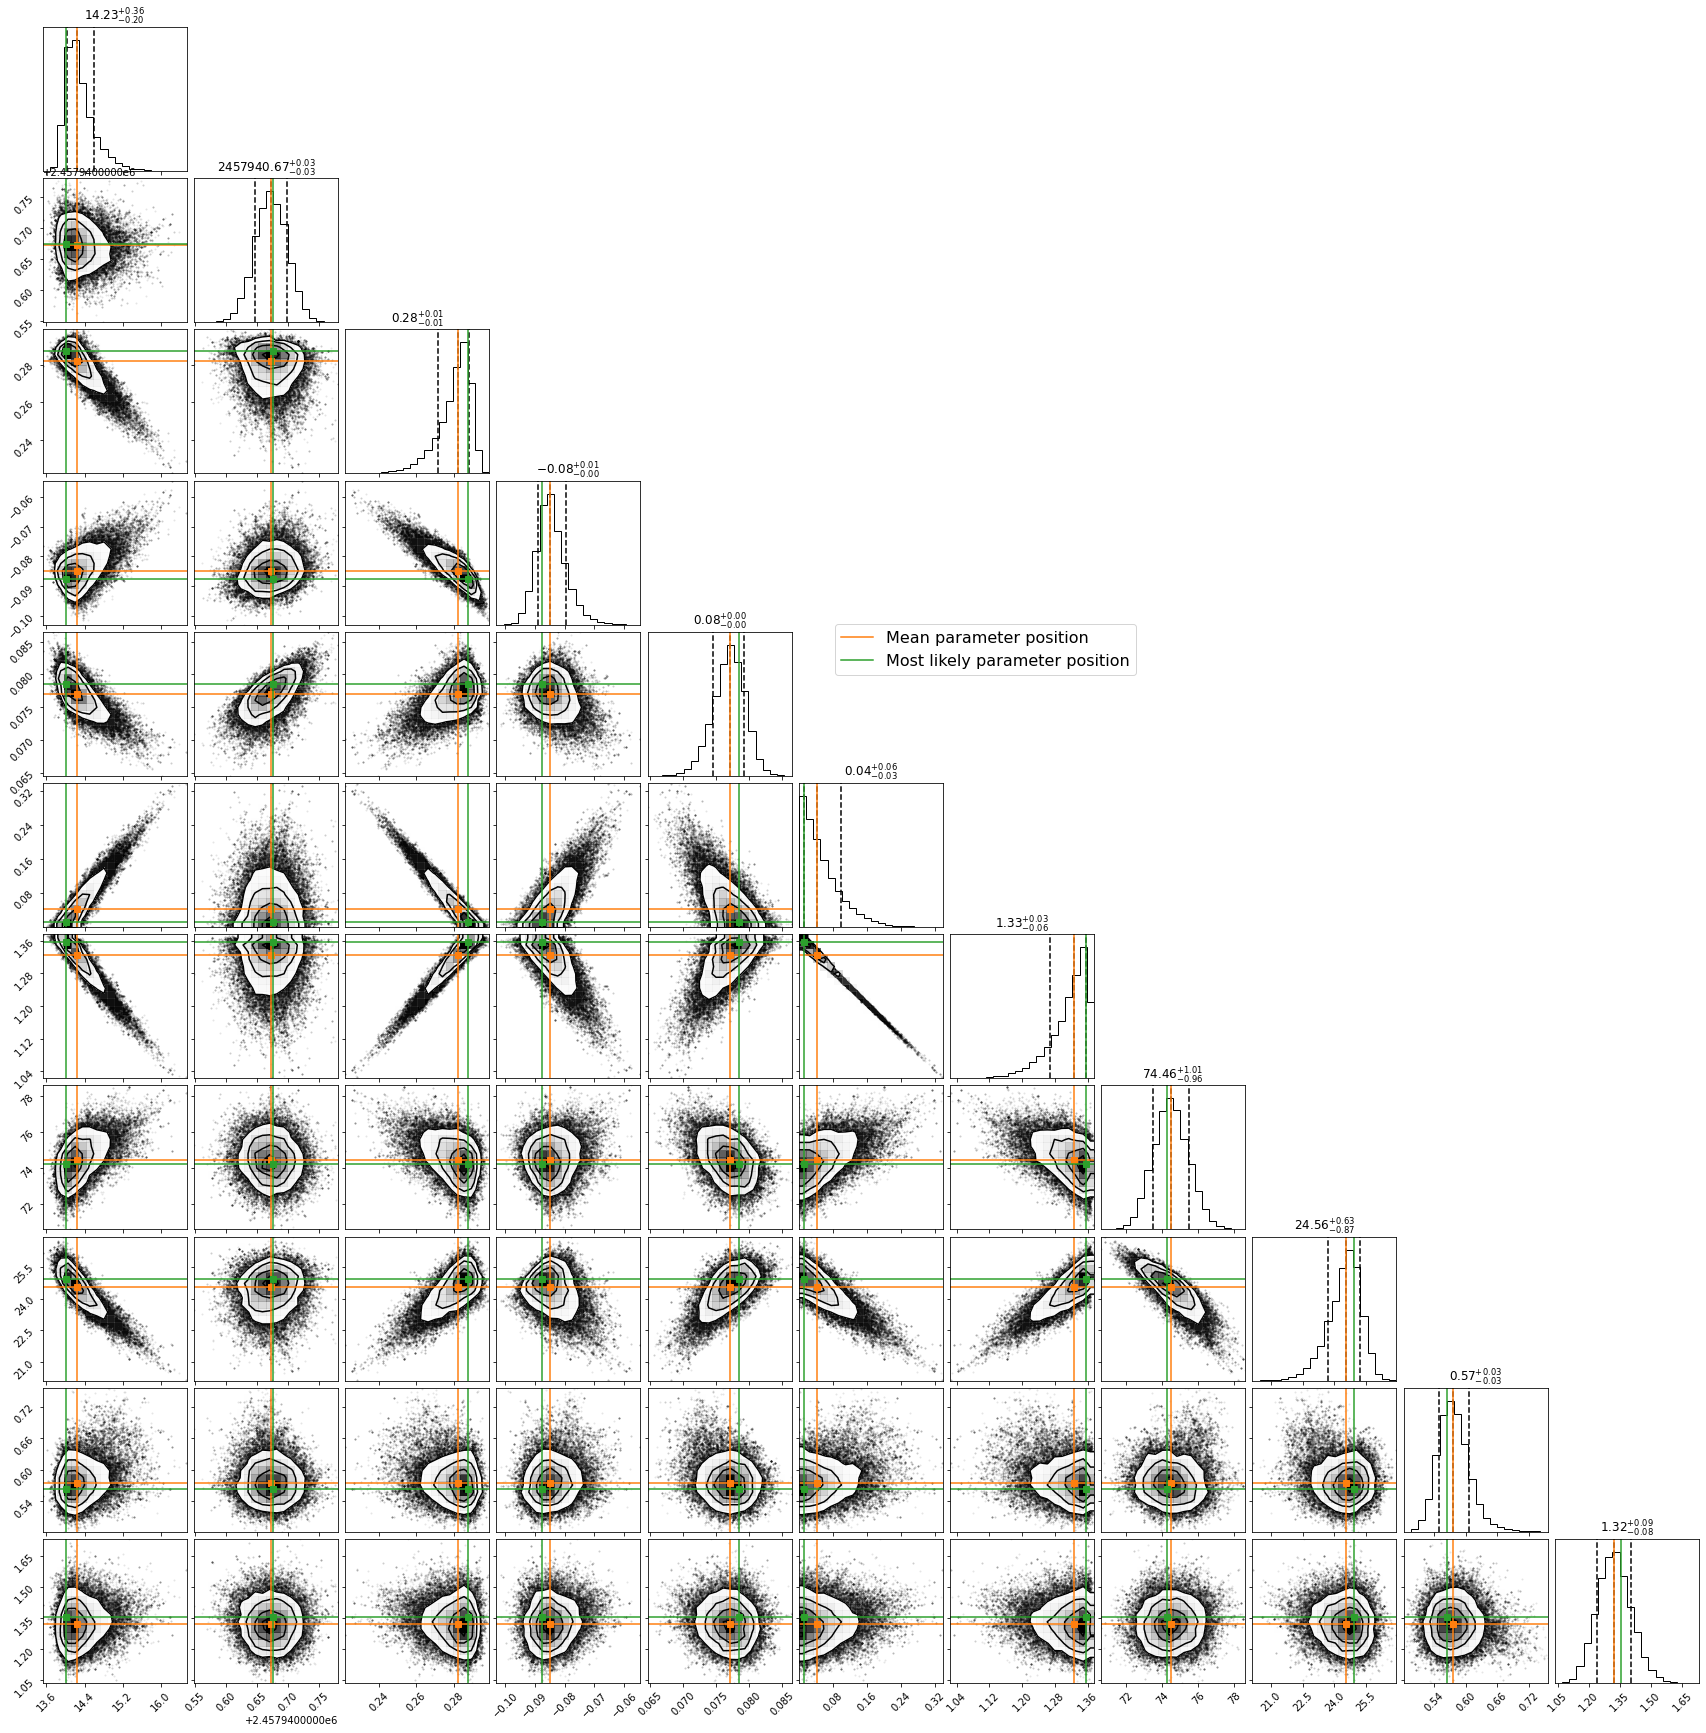

In [14]:
# Create corner plots to check for convergence
# 1d array of samples
samples = pos_chain.reshape((-1, len(popt_mcmc)))

# corner plot
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12})

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

plt.legend(loc=(-5,7),fontsize=16)

In [15]:
# Re-run MCMC if it does not look converged. This cell can be run repeatedly.
rerun_mcmc = False
if rerun_mcmc:
    # Create wrapper object for PLD coefficient chain to make it mutable 
    PLD_chain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
    # generate the MCMC sampler
    sampler = mcmc.get_MCMC_sampler(popt_mcmc,MODELFUNC,times,ptot,ptot_err,err_bin,pnorm,PLD_chain,pool=Pool(),bounds=bounds)
    # Initialize the initial parameter positions as the previous final parameter positions
    pos0 = pos_final
    # Run production
    pos_final,prob_final,state_final = mcmc.run_mcmc(sampler,pos0,3000,label='production')
    # Save results
    pos_chain = sampler.chain
    pld_chain = PLD_chain.chain
    lnp_chain = sampler.lnprobability
    mcmc.save_results(EVENT_NAME,pos_chain,pos_final,lnp_chain,pld_chain,folder=MODELNAME)
    # Get results from chain
    popt_mcmc,pmax,std_hi,std_lo = mcmc.get_MCMC_results(pos_chain,lnp_chain)

In [16]:
Y, Astro, Ps, A, X, flu_g = PLD.analytic_solution(time,flux,flux_err,flux_frac,pmax[:-2],model,time_g)
# Get detector model and divide it out to get new best-fit
fit_mcmc,sys_mcmc,corr_mcmc,resi_mcmc = PLD.get_bestfit(A, Ps, X, flux, Astro)
# Compute RMS error before and after
RMS_mcmc = PLD.get_RMS(resi_mcmc,label='RMS after MCMC',visual=True)
# Plot corrected data, corrected model, and residuals

RMS after MCMC  :  9.79140288172928


# Analysis

In [17]:
# Compute BIC
bic = mcmc.get_BIC(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, X)
print(bic)

NameError: name 'MODELFUNC' is not defined

In [ ]:
resi_corr = corr_mcmc-MODELFUNC(time,*popt_mcmc)
std = resi_corr.std()
indmax = np.argmax(np.abs(resi_corr))
timemax,resimax = time[indmax],resi_corr[indmax]

fig,ax = plt.subplots(figsize=(7,5))
ax.plot(time,resi_corr,'.',label='Residuals')
ax.plot(timemax,resimax,marker='s',fillstyle='none',color='red',markersize=10)
ax.text(timemax+0.7,resimax-0.3,'Peak fluctuation',fontsize=12)

ax.axhline(y=0,color='C1')
#ax.text(time[-1]+2.1,-0.1,r'best fit')
for i in range(1,5):
    ax.axhline(y=i*std,color='C1',ls='--',alpha=1-0.2*i)
    ax.axhline(y=-i*std,color='C1',ls='--',alpha=1-0.2*i)
    ax.text(time[-1]+2,i*std-0.1,r'$+%d\sigma$'%i)
    ax.text(time[-1]+2,-i*std-0.1,r'$-%d\sigma$'%i)
    
ax.set_ylabel('Residuals (MJy/sr)',fontsize=16)
ax.set_xlabel('Time (JD)',fontsize=16)

ax.legend(fontsize=12)

In [ ]:
pmin, pmax = 0, np.max(ptot)+5

# ylim for residuals
resi_std   = np.std(resi)
rmin, rmax = -4*resi_std, 4*resi_std

fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize = (8, 9))

axes[0].plot(time, ptot, '.', label = 'Data')
axes[0].plot(time, fit, '.', label= 'Signal Fit', color='C1', alpha=0.5)
axes[0].set_ylabel('Photometry (MJy/str)', fontsize=13)
axes[0].set_ylim(pmin, pmax)
axes[0].legend()

axes[1].plot(time, corr, '.', label='Corrected Data', alpha=0.5)
axes[1].plot(timeplot, lcoptim, label='Astrophysical Model', color='C1', linewidth=3,alpha=0.5)
axes[1].set_ylabel('Photometry (MJy/str)', fontsize=13)
axes[1].set_ylim(pmin, pmax)
axes[1].legend()

axes[2].plot(time, resi, '.', label='Residuals', alpha=0.5)
axes[2].axhline(y=0, color='C1', linewidth=3,alpha=0.5)
axes[2].set_ylabel('Residuals (MJy/str)', fontsize=13)
axes[2].set_xlabel('Time (JD)', fontsize=13)
axes[2].set_ylim(rmin, rmax)
axes[2].legend()

axes[2].set_xlim(np.min(timeplot), np.max(timeplot))

fig.subplots_adjust(hspace = 0)